In [1]:
import os

os.chdir(r"C:\Users\User\Proje_klasörü")
print("CWD:", os.getcwd())
print("Here:", os.listdir("."))

DATA_DIR = "DATA_DIR"
ALL_DIR = os.path.join(DATA_DIR, "all")

print("ALL_DIR exists:", os.path.exists(ALL_DIR))
print("Folders:", os.listdir(ALL_DIR))


CWD: C:\Users\User\Proje_klasörü
Here: ['.ipynb_checkpoints', 'DATA_DIR', 'Untitled10.ipynb']
ALL_DIR exists: True
Folders: ['Cloudy', 'Rain', 'Shine', 'Sunrise']


In [3]:
import random, hashlib
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report)

import matplotlib.pyplot as plt

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cuda


In [5]:
BATCH_SIZE = 32
EPOCHS = 20
NUM_WORKERS = 0  # Windows stabil

IMG_SIZE = 224

LR = 2e-4
WEIGHT_DECAY = 5e-4
LABEL_SMOOTHING = 0.15
PATIENCE = 4

print("Settings loaded.")


Settings loaded.


In [7]:
class_names = sorted([d for d in os.listdir(ALL_DIR) if os.path.isdir(os.path.join(ALL_DIR, d))])
class_to_idx = {c:i for i,c in enumerate(class_names)}
idx_to_class = {i:c for c,i in class_to_idx.items()}

paths, labels = [], []
for c in class_names:
    cdir = os.path.join(ALL_DIR, c)
    for fn in os.listdir(cdir):
        if fn.lower().endswith((".jpg",".jpeg",".png",".webp")):
            paths.append(os.path.join(cdir, fn))
            labels.append(class_to_idx[c])

paths = np.array(paths)
labels = np.array(labels)

print("Classes:", class_names)
print("Total images:", len(paths))
for c in class_names:
    print(f"{c:10s} :", np.sum(labels == class_to_idx[c]))


Classes: ['Cloudy', 'Rain', 'Shine', 'Sunrise']
Total images: 1125
Cloudy     : 300
Rain       : 215
Shine      : 253
Sunrise    : 357


In [9]:
from sklearn.model_selection import train_test_split

# 1️⃣ Önce test ayır ( %15 )
train_p, test_p, train_y, test_y = train_test_split(
    paths, labels,
    test_size=0.15,
    random_state=42,
    stratify=labels
)

# 2️⃣ Train içinden validation ayır ( %15 of total ≈ 0.1765 of train )
train_p, val_p, train_y, val_y = train_test_split(
    train_p, train_y,
    test_size=0.1765,
    random_state=42,
    stratify=train_y
)

print("Split sizes:")
print("Train:", len(train_p))
print("Val  :", len(val_p))
print("Test :", len(test_p))
print("Sum  :", len(train_p) + len(val_p) + len(test_p))


Split sizes:
Train: 787
Val  : 169
Test : 169
Sum  : 1125


In [11]:
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    transforms.RandomErasing(p=0.35, scale=(0.02, 0.15), ratio=(0.3, 3.3), value="random")
])

eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [13]:
class WeatherDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = list(paths)
        self.labels = list(labels)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        y = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, y

train_ds = WeatherDataset(train_p, train_y, train_tf)
val_ds   = WeatherDataset(val_p,   val_y,   eval_tf)
test_ds  = WeatherDataset(test_p,  test_y,  eval_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("Loaders ready.")


Loaders ready.


In [15]:
NUM_CLASSES = len(class_names)

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
in_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Dropout(p=0.35),
    nn.Linear(in_features, NUM_CLASSES)
)

model = model.to(DEVICE)
print("ResNet50 ready.")


ResNet50 ready.


In [17]:
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2
)


In [19]:
def train_one_epoch(model, loader):
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()

        preds = out.argmax(dim=1)
        running_loss += loss.item() * x.size(0)
        running_correct += (preds == y).sum().item()
        total += x.size(0)

    return running_loss / total, running_correct / total


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    running_loss, running_correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        out = model(x)
        loss = criterion(out, y)
        preds = out.argmax(dim=1)

        running_loss += loss.item() * x.size(0)
        running_correct += (preds == y).sum().item()
        total += x.size(0)

    return running_loss / total, running_correct / total


In [21]:
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

best_val_acc = -1
best_state = None
pat_counter = 0

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    va_loss, va_acc = evaluate(model, val_loader)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    scheduler.step(va_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.4f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        pat_counter = 0
    else:
        pat_counter += 1
        if pat_counter >= PATIENCE:
            print("Early stopping!")
            break

print("Best Val Acc:", best_val_acc)


Epoch 01/20 | train loss 0.9598 acc 0.7878 | val loss 0.6064 acc 0.9467
Epoch 02/20 | train loss 0.5816 acc 0.9606 | val loss 0.5374 acc 0.9704
Epoch 03/20 | train loss 0.5426 acc 0.9746 | val loss 0.5186 acc 0.9822
Epoch 04/20 | train loss 0.5284 acc 0.9797 | val loss 0.5198 acc 0.9822
Epoch 05/20 | train loss 0.5205 acc 0.9873 | val loss 0.5271 acc 0.9763
Epoch 06/20 | train loss 0.5188 acc 0.9809 | val loss 0.5139 acc 0.9882
Epoch 07/20 | train loss 0.5048 acc 0.9949 | val loss 0.5229 acc 0.9763
Epoch 08/20 | train loss 0.4990 acc 0.9962 | val loss 0.5221 acc 0.9704
Epoch 09/20 | train loss 0.4999 acc 0.9949 | val loss 0.5313 acc 0.9763
Epoch 10/20 | train loss 0.4957 acc 0.9987 | val loss 0.5437 acc 0.9645
Early stopping!
Best Val Acc: 0.9881656804733728


In [23]:
model.load_state_dict(best_state)
model = model.to(DEVICE)
print("Loaded best model.")


Loaded best model.


In [25]:
@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    all_preds, all_true = [], []

    for x, y in loader:
        x = x.to(DEVICE)
        out = model(x)
        preds = out.argmax(dim=1).cpu().numpy()

        all_preds.extend(list(preds))
        all_true.extend(list(y.numpy()))

    return np.array(all_true), np.array(all_preds)

y_true, y_pred = predict_all(model, test_loader)

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
rec  = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1   = f1_score(y_true, y_pred, average="macro", zero_division=0)

print("TEST METRICS")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1       :", f1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


TEST METRICS
Accuracy : 0.9881656804733728
Precision: 0.9893617021276596
Recall   : 0.9868421052631579
F1       : 0.9878084606345476

Classification Report:

              precision    recall  f1-score   support

      Cloudy       0.96      1.00      0.98        45
        Rain       1.00      1.00      1.00        32
       Shine       1.00      0.95      0.97        38
     Sunrise       1.00      1.00      1.00        54

    accuracy                           0.99       169
   macro avg       0.99      0.99      0.99       169
weighted avg       0.99      0.99      0.99       169



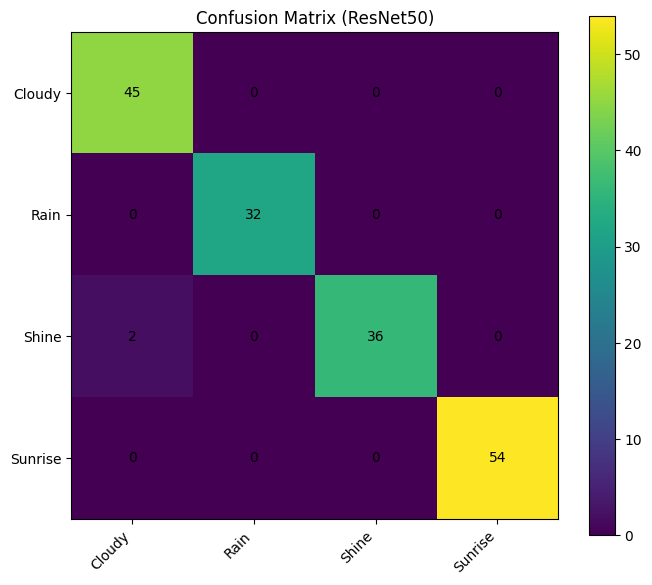

In [27]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
plt.imshow(cm)
plt.title("Confusion Matrix (ResNet50)")
plt.colorbar()
plt.xticks(range(NUM_CLASSES), class_names, rotation=45, ha="right")
plt.yticks(range(NUM_CLASSES), class_names)

for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


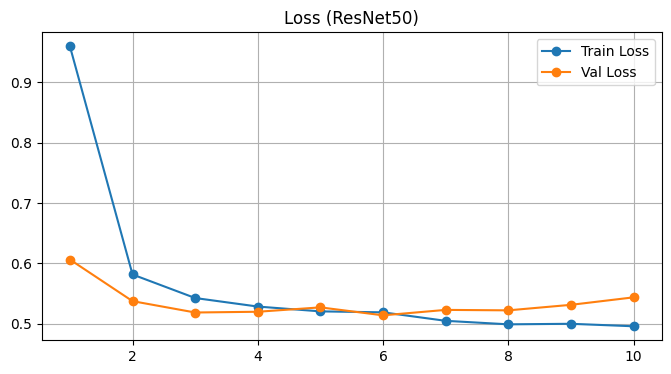

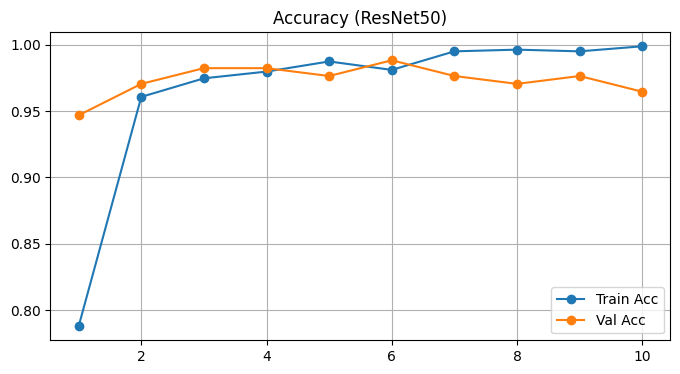

In [29]:
epochs_ran = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(8,4))
plt.plot(epochs_ran, history["train_loss"], marker="o", label="Train Loss")
plt.plot(epochs_ran, history["val_loss"], marker="o", label="Val Loss")
plt.title("Loss (ResNet50)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs_ran, history["train_acc"], marker="o", label="Train Acc")
plt.plot(epochs_ran, history["val_acc"], marker="o", label="Val Acc")
plt.title("Accuracy (ResNet50)")
plt.legend()
plt.grid(True)
plt.show()


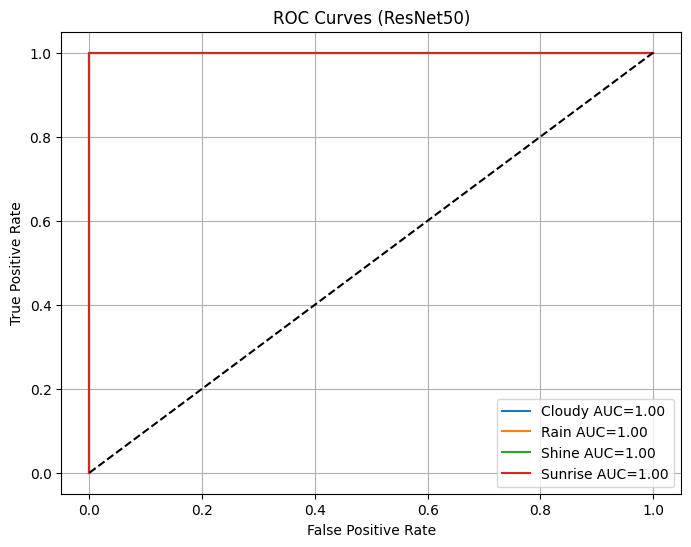

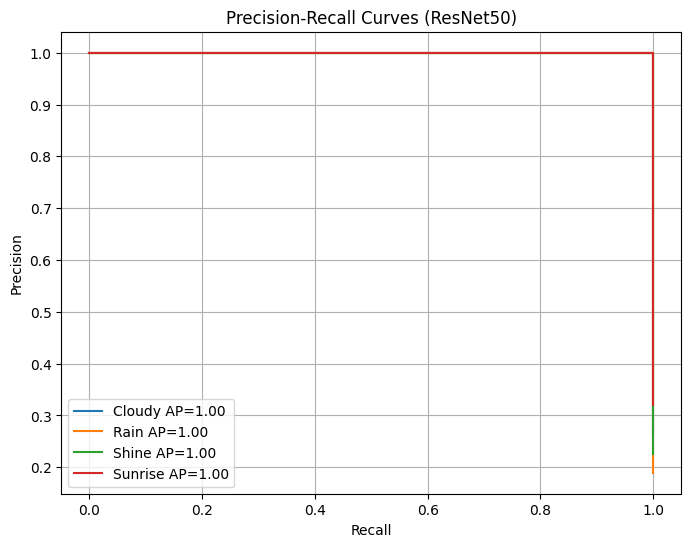

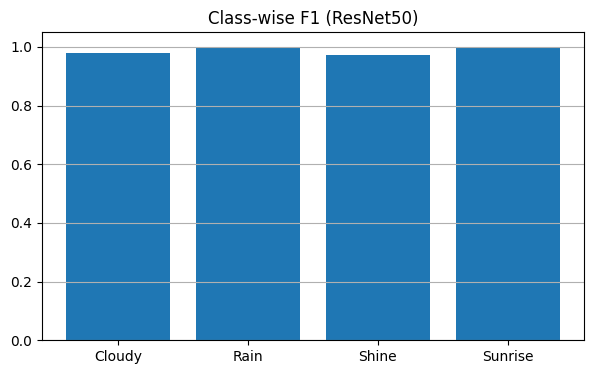

In [31]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

@torch.no_grad()
def collect_probs(model, loader):
    model.eval()
    all_probs, all_true = [], []
    for x, y in loader:
        x = x.to(DEVICE)
        out = model(x)
        probs = torch.softmax(out, dim=1).cpu().numpy()
        all_probs.append(probs)
        all_true.append(y.numpy())
    return np.concatenate(all_true), np.vstack(all_probs)

y_true_curve, y_prob_curve = collect_probs(model, test_loader)
y_true_bin = label_binarize(y_true_curve, classes=list(range(NUM_CLASSES)))

# ROC
plt.figure(figsize=(8,6))
for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob_curve[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} AUC={roc_auc:.2f}")
plt.plot([0,1], [0,1], "k--")
plt.title("ROC Curves (ResNet50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall
plt.figure(figsize=(8,6))
for i, cls in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_prob_curve[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_prob_curve[:, i])
    plt.plot(recall, precision, label=f"{cls} AP={ap:.2f}")
plt.title("Precision-Recall Curves (ResNet50)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

# Class-wise F1
from sklearn.metrics import f1_score
y_pred_curve = np.argmax(y_prob_curve, axis=1)
f1_each = f1_score(y_true_curve, y_pred_curve, average=None)

plt.figure(figsize=(7,4))
plt.bar(class_names, f1_each)
plt.title("Class-wise F1 (ResNet50)")
plt.ylim(0, 1.05)
plt.grid(True, axis="y")
plt.show()


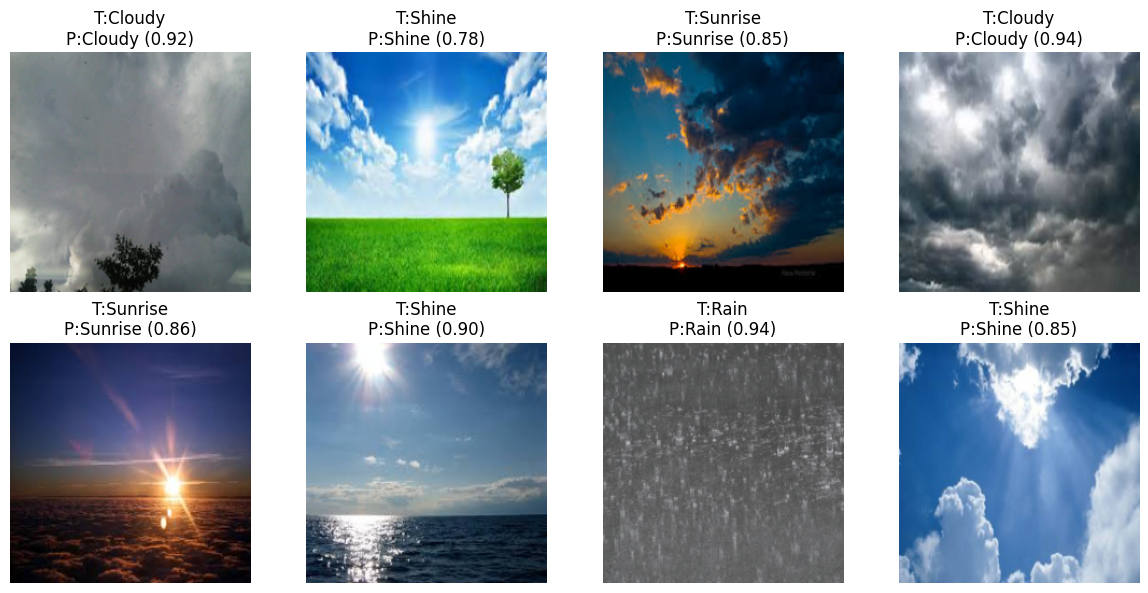

In [37]:
@torch.no_grad()
def show_samples(model, dataset, n=8):
    model.eval()
    idxs = np.random.choice(len(dataset), n, replace=False)

    plt.figure(figsize=(12,6))
    for i, idx in enumerate(idxs):
        x, y = dataset[idx]
        x_in = x.unsqueeze(0).to(DEVICE)

        out = model(x_in)
        prob = torch.softmax(out, dim=1)[0]
        pred = prob.argmax().item()

        # denormalize
        img = x.permute(1,2,0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std  = np.array([0.229, 0.224, 0.225])
        img = img * std + mean
        img = np.clip(img, 0, 1)

        plt.subplot(2, n//2, i+1)
        plt.imshow(img)
        plt.title(f"T:{class_names[y]}\nP:{class_names[pred]} ({prob[pred]:.2f})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_samples(model, test_ds, n=8)
